In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector

import matplotlib
import random
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ipywidgets import widgets
from IPython.display import display
import IPython.display
import statistics
from enum import Enum, auto
from collections import OrderedDict

In [2]:
# Matplotlib adds a scrollbar too easily, which ruins setting up a "dashboard". This code/hack prevents scrollbars.
from IPython.display import Javascript
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

In [3]:
def gini(x): # from http://stackoverflow.com/a/39513799
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [4]:
class TechDevType(Enum):
    LINEAR = auto()
    EXPONENTIAL = auto()
    
    def __str__(self):
        return self.name


class StochasticityType(Enum):
    NONE = auto()
    BINARY = auto()
    BETA = auto()
    
    def __str__(self):
        return self.name

    
class SharingType(Enum):
    NONE = auto()
    ALL = auto()
    LEADER = auto()
    SIMILAR_THRESHOLD = auto()
    SIMILAR_LINEAR = auto()
    SIMILAR_LEADER_THRESHOLD = auto()
    PROPORTIONAL_GAIN_FROM_ALL = auto()
    ALL_TO_ALL = auto()
    
    def __str__(self):
        return self.name


class DistributionType(Enum):
    NONE = auto()
    BERNOULLI = auto()
    UNIFORM = auto()
    BETA = auto()
    
    def __str__(self):
        return self.name


# str method that works like expected on tuples with Enum elements (actually uses their specific __str__.)
# str((DistributionType.BETA,1,2)) gives '(<DistributionType.BETA: 4>, 1, 2)'
# str_without_tuple_insanity((DistributionType.BETA,1,2)) gives '(BETA, 1, 2)'
def str_without_tuple_insanity(s):
    if isinstance(s, tuple):
        return '(' + ', '.join([str(e) for e in s]) + ')'
    else:
        return str(s)

In [5]:
class DeveloperAgent(Agent):
    def __init__(self, unique_id, model, ufr_stochasticity, ufr_max):
        super().__init__(unique_id, model)
        self.capability = 10 * random.random()
        
        ufr_stochasticity_type = ufr_stochasticity[0]
        assert ufr_stochasticity_type is DistributionType.UNIFORM or ufr_stochasticity_type is DistributionType.BETA
        if ufr_stochasticity_type is DistributionType.UNIFORM:
            self.utility_function_rating = ufr_max * random.random()
        else: #ufr_stochasticity_type is DistributionType.BETA:
            shape_parameter_alpha = ufr_stochasticity[1]
            shape_parameter_beta = ufr_stochasticity[2]
            self.utility_function_rating = ufr_max * random.betavariate(shape_parameter_alpha, shape_parameter_beta)

    def step(self):
        pass
    
    def calculate_ufr_difference(self, other):
        return abs(other.utility_function_rating - self.utility_function_rating)
    
    def calculate_ufr_similarity(self, other):
        ufr_difference = self.calculate_ufr_difference(other)
        if ufr_difference == 0.0:
            return 1
        return min(1, 1 / ufr_difference)


class DevelopmentModel(Model):
    too_large_increase = 0
    def __init__(self, agent_count, ufr_stochasticity, ufr_max, tech_dev_type, tech_dev_stochasticity, tech_dev_factor, 
                 sharing_threshold, sharing_factor, sharing_type, fixed_random_seed):
        self.tech_dev_type = tech_dev_type
        self.tech_dev_stochasticity = tech_dev_stochasticity
        self.tech_dev_factor = tech_dev_factor
        self.sharing_threshold = sharing_threshold
        self.sharing_factor = sharing_factor
        self.sharing_type = sharing_type
        self.schedule = RandomActivation(self) # TODO: Can the seed for this be fixed? This will be important when the agents do individual actions.
        self.running = True
        # Create agents
        if fixed_random_seed:
            random.seed(1)
        for i in range(agent_count):
            a = DeveloperAgent(i, self, ufr_stochasticity, ufr_max)
            self.schedule.add(a)
  
        self.datacollector = DataCollector(
            #model_reporters={"gini" : compute_model_gini},
            agent_reporters={"capability" : lambda a: a.capability,
                             "ufr" : lambda a: a.utility_function_rating})
    def step(self):
        self.datacollector.collect(self)
        
        # Add increase from innate development
        stochasticity_factor = 1
        tech_dev_stochasticity_type = self.tech_dev_stochasticity[0]
        if tech_dev_stochasticity_type is DistributionType.UNIFORM:
            stochasticity_factor = random.random()
        if tech_dev_stochasticity_type is DistributionType.BERNOULLI:
            p = self.tech_dev_stochasticity[1]
            stochasticity_factor = 1 if random.random() < p else 0
        if tech_dev_stochasticity_type is DistributionType.BETA:
            shape_parameter_alpha = self.tech_dev_stochasticity[1]
            shape_parameter_beta = self.tech_dev_stochasticity[2]
            stochasticity_factor = random.betavariate(shape_parameter_alpha, shape_parameter_beta)
        else: # if tech_dev_stochasticity_type is DistributionType.NONE:
            pass
        
        if self.tech_dev_type == TechDevType.LINEAR:
            for agent in self.schedule.agents:
                agent.capability += (self.tech_dev_factor * SIMULATION_SPEED * stochasticity_factor)
        elif self.tech_dev_type == TechDevType.EXPONENTIAL:
            for agent in self.schedule.agents:
                agent.capability += agent.capability * (self.tech_dev_factor * SIMULATION_SPEED * stochasticity_factor)

        # Add increase from sharing
        capabilities = [a.capability for a in self.schedule.agents]
        agent_count = len(self.schedule.agents)
        largest_capability = max(capabilities)

        new_capabilities = list(capabilities)
        cap_from_sharing = [0.0 for _ in range(agent_count)]
        for index in range(agent_count):
            agent = self.schedule.agents[index]
            # in NONE, there is no capability increase from sharing.
            if self.sharing_type is SharingType.NONE:
                pass
            # in LEADER, agents get some fraction of the leader's capabilities.
            elif self.sharing_type is SharingType.LEADER:
                cap_from_sharing[index] = (largest_capability - agent.capability) * self.sharing_factor
            # in SIMILAR_LEADER_THRESHOLD, The agent get a fraction of the difference between their capability and, 
            # from the set of similar agents, the capability of the agent farthest ahead
            elif self.sharing_type is SharingType.SIMILAR_LEADER_THRESHOLD:
                similar_agents = []
                for other_agent in self.schedule.agents:
                    ufr_difference = agent.calculate_ufr_difference(other_agent)
                    if ufr_difference < self.sharing_threshold:
                        similar_agents.append(other_agent)
                if similar_agents:
                    similar_agents_capabilities = [a.capability for a in similar_agents]
                    largest_cap_among_similar_agents = max(similar_agents_capabilities)
                    if largest_cap_among_similar_agents > agent.capability:
                        cap_from_sharing[index] = (largest_cap_among_similar_agents - agent.capability) * self.sharing_factor
            else:
                for other_agent in self.schedule.agents:
                    if agent is other_agent:
                        continue
                    capability_difference = other_agent.capability - agent.capability
                    if capability_difference <= 0.0:
                        continue
            # in ALL, agents get a fraction of everyone's capability above them. 
                    if self.sharing_type is SharingType.ALL:
                        cap_from_sharing[index] += capability_difference * self.sharing_factor
                    elif self.sharing_type is SharingType.SIMILAR_THRESHOLD:
                        ufr_difference = agent.calculate_ufr_difference(other_agent)
            #capability difference if statement here?
            # in SIMILAR_THRESHOLD, agents get a fraction of the capabilities of everyone above them with similar enough UFs.          
                        if ufr_difference < self.sharing_threshold:
                            cap_from_sharing[index] += capability_difference * self.sharing_factor
            # in SIMILAR_LINEAR, agents get a fraction of the difference between their capability and the capability 
            #of all agents ahead of it, scaled by how similar the agents are.
                    elif self.sharing_type is SharingType.SIMILAR_LINEAR:
                        ufr_similarity = agent.calculate_ufr_similarity(other_agent)
                        cap_from_sharing[index] += capability_difference * ufr_similarity * self.sharing_factor
            # in PROPORTIONAL_GAIN_FROM_ALL, everyone gains from everyone above in proportion to their closeness to the current peak. 
                    elif self.sharing_type is SharingType.PROPORTIONAL_GAIN_FROM_ALL:    
                        cap_from_sharing[index] += other_agent.capability * agent.capability / largest_capability * self.sharing_factor
                    elif self.sharing_type is SharingType.ALL_TO_ALL:
                        cap_from_sharing[index] += other_agent.capability * self.sharing_factor
            # The sharing logic right now does not cap how much an agent might get from others. Sanity check.
            if new_capabilities[index] > largest_capability:
                DevelopmentModel.too_large_increase += 1
        for index in range(agent_count):
            agent = self.schedule.agents[index]
            agent.capability += cap_from_sharing[index] * SIMULATION_SPEED

        self.schedule.step()

In [6]:
def plot_capabilities(chart_type, agent_caps_histories, utility_function_ratings, step, 
                      label, y_max):
    agent_capabilities = agent_caps_histories[step]
    agent_count = len(agent_capabilities)
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    if y_max > 0.0:
        axes.set_ylim([0.0, y_max])
    
    if chart_type == 'uf-capability scatter plot':
        #plt.hist(agent_capabilities, label=label, bins=len(agent_capabilities))
        for index in range(len(utility_function_ratings)):
            plt.scatter(utility_function_ratings[index], agent_capabilities[index])
        #plt.scatter(utility_function_ratings, agent_capabilities, label=label)
    elif (chart_type == 'progress chart'):
        caps_histories_by_agent = agent_caps_histories.swaplevel(0, 1)
        for agent_id in range(agent_count):
            agent_cap_history = caps_histories_by_agent[agent_id]
            plt.plot(range(step+1), agent_cap_history[:step+1])
    else: # 'capability histogram'
        plt.hist(agent_capabilities, label=label, bins=len(agent_capabilities))
        plt.legend(loc = "upper left")

    plt.show()

def plot_utility_function_ratings(utility_function_ratings):
    #plt.hist(utility_function_ratings, color="red", label="utility function ratings")
    #plt.plot(utility_function_ratings, color='red', label="utility function ratings")
    #plt.scatter(range(len(utility_function_ratings)), utility_function_ratings, color='red',
    #            label="utility function ratings")
    plt.scatter(utility_function_ratings, range(len(utility_function_ratings)), color='red',
                label="utility function ratings")
    plt.legend()
    plt.show()

def draw_plots(step, chart_type, agent_caps_histories, utility_function_ratings, y_max):
    label = "Capabilities, step " + str(step)
    plot_capabilities(chart_type, agent_caps_histories, utility_function_ratings, step, label, y_max)
    plot_utility_function_ratings(utility_function_ratings)

def draw_dashboard(simulation_steps, model_histories):
    model_dropdown_options = list(model_histories.keys())
    model_dropdown = widgets.Dropdown(options=model_dropdown_options, description='Model', disabled=False,
        layout=widgets.Layout(display='flex', flex_flow='row', justify_content='space-between')
                                      #button_style='' # 'success', 'info', 'warning', 'danger' or ''
    )
    step_slider = widgets.IntSlider(min=0, max=(simulation_steps-1), step=1, value=0, 
                                   layout=widgets.Layout(width='800px'))
    
    cap_chart_type_buttons = widgets.RadioButtons(options=['uf-capability scatter plot', 
                                                           'capability histogram',
                                                            'progress chart'])
    #y_max_text_field = widgets.FloatText()
    
    stats_labels = [widgets.Label('Lowest'), widgets.Label('Highest'), widgets.Label('Median'), 
                    widgets.Label('Gini')]
    stats_values = [widgets.Label(), widgets.Label(), widgets.Label(), widgets.Label()]
    stats_box = widgets.VBox([widgets.HBox(stats_labels), widgets.HBox(stats_values)])
    
    @widgets.interact(model=model_dropdown, step=step_slider, chart_type=cap_chart_type_buttons, )
                      #y_max=y_max_text_field)
    def plot(model, step, chart_type): #, y_max):
        if step >= 0:
            model_history = model_histories[model]
            agent_caps_histories = model_history.capability
            ufrs = model_history.ufr[0] # Ufrs don't vary, so we just select them from step 0
            
            draw_plots(step, chart_type, agent_caps_histories, ufrs, 0)#float(y_max))
            capabilities = agent_caps_histories[step]
            stats_values[0].value = '%.2f'%min(capabilities)
            stats_values[1].value = '%.2f'%max(capabilities)
            stats_values[2].value = '%.2f'%statistics.median(capabilities)
            stats_values[3].value = '%.4f'%gini(capabilities)
    
    display(stats_box)

    if DevelopmentModel.too_large_increase > 0:
        print('Count, over all steps, of agents given a sharing bonus that put them ahead of ' +
          'what the leader had before sharing: ' + str(DevelopmentModel.too_large_increase))

In [7]:
# Test that arg behaves like a sequence (get_item, iter) -- like a list, and not like a string (strip).
def is_sequence(arg):
    return (not hasattr(arg, "strip") and
            hasattr(arg, "__getitem__") or
            hasattr(arg, "__iter__"))

def validate_parameters(parameters):
    # Validate that every parameter value is in list/sequence form
    for parameter_name, parameter_value in parameters.items():
        assert is_sequence(parameter_value), "Parameter '" + parameter_name + "' has value '" + str(parameter_value) \
        + "' which isn't a sequence. Did you forget to add brackets?"
    
    # Validate distribution parameters
    for key, value in parameters.items():
        if key == "ufr_stochasticity" or key == "tech_dev_stochasticity":
            for variant in value:
                assert isinstance(variant, tuple), 'Distribution values have to be tuples. Did you forget the trailing ","? '

def create_batch_runner(parameters, simulation_steps):
    return BatchRunner(DevelopmentModel,
                       parameters,
                       iterations=1,
                       max_steps=simulation_steps,
                       model_reporters={"datacollectors": lambda a: a.datacollector})

# Repackage the collected data into a more useful and presentable form
def get_model_histories(batch_runner, parameter_names_in_order):
    run_data = batch_runner.get_model_vars_dataframe()
    model_histories = {}
    for _, row in run_data.iterrows():
        model_parameters = row.drop(['datacollectors', 'Run'])
        parameters_ordered = [model_parameters[parameter_name] for parameter_name in parameter_names_in_order]
        model_identifier = ','.join(str_without_tuple_insanity(parameter).replace(' ', '') for parameter in parameters_ordered)
        model_history = row.datacollectors.get_agent_vars_dataframe()
        model_histories[model_identifier] = model_history
    return model_histories

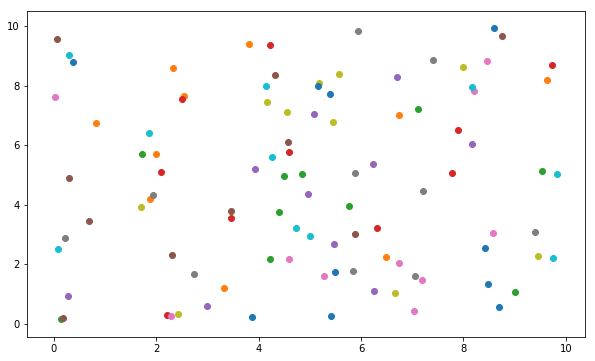

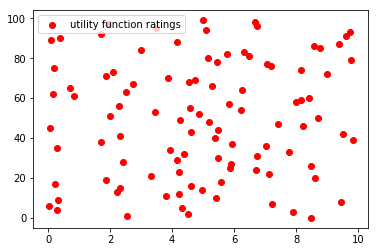

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [8]:
SIMULATION_SPEED = 1.0
simulation_steps = 20

# This is an OrderedDict so we can keep the order written here when we display things like in the dropdowns
parameters = OrderedDict([("agent_count", [100]),
                          ("ufr_stochasticity", [(DistributionType.UNIFORM,), ]),#(DistributionType.BETA, 1, 3)]),
                          ("ufr_max", [10]),
                          ("tech_dev_type", [TechDevType.EXPONENTIAL]),
                          ("tech_dev_stochasticity", [(DistributionType.NONE,), #(DistributionType.UNIFORM,),
                                                     #(DistributionType.BERNOULLI, 0.5), (DistributionType.BETA, 1, 3)],
                                                     ]),
                          ("tech_dev_factor", [10.0]),
                          ("sharing_type", [SharingType.SIMILAR_THRESHOLD]),
                          ("sharing_factor", np.arange(0, 1.1, 0.1)),
                          ("sharing_threshold", np.arange(0, 1.1, 0.1)),
                          ("fixed_random_seed", [True]),])

validate_parameters(parameters)

batch_runner = create_batch_runner(parameters, simulation_steps)
batch_runner.run_all()
model_histories = get_model_histories(batch_runner, parameters.keys())
draw_dashboard(simulation_steps, model_histories)

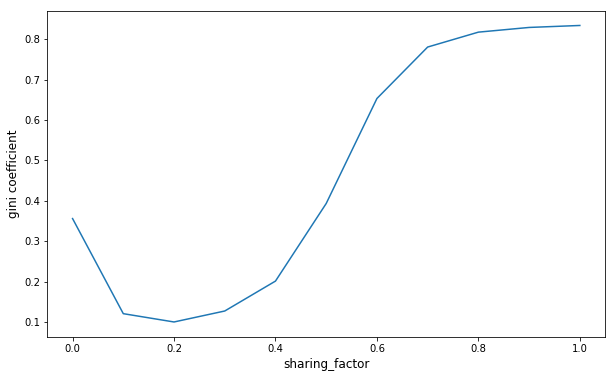

0: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.0,0.2,True
1: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.1,0.2,True
2: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.2,0.2,True
3: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.30000000000000004,0.2,True
4: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.4,0.2,True
5: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.5,0.2,True
6: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.6000000000000001,0.2,True
7: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.7000000000000001,0.2,True
8: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.8,0.2,True
9: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,0.9,0.2,True
10: 100,(UNIFORM),10,EXPONENTIAL,(NONE),10.0,SIMILAR_THRESHOLD,1.0,0.2,True


In [9]:
run_data = batch_runner.get_model_vars_dataframe()
model_histories = {}
model_ids = []
for _, row in run_data.iterrows():
    model_parameters = row.drop(['datacollectors', 'Run'])
    parameters_ordered = [model_parameters[parameter_name] for parameter_name in parameters.keys()]
    model_identifier = ','.join(str_without_tuple_insanity(parameter).replace(' ', '') for parameter in parameters_ordered)
    model_ids.append(model_identifier)
    model_history = row.datacollectors.get_agent_vars_dataframe()
    model_histories[model_identifier] = model_history
run_data['identifier'] = model_ids # "Shortcut" way of adding a column http://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas


def plot_model_ginis(ginis, x_values, x_label):
    fig = plt.gcf()
    fig.set_size_inches(10, 6)    
    #fig.suptitle('test title', fontsize=20)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel('gini coefficient', fontsize=12)
    plt.plot(x_values, ginis)
    plt.show()
    
def set_dropdowns(dropdowns, parameters):
    for dropdown, (parameter_name, parameter_value) in zip(dropdowns, parameters):
        dropdown.description = parameter_name
        dropdown.options = list(parameter_value)

def draw_multi_model_dashboard(simulation_steps, run_data, model_histories, varying_parameters):
    parameter_dropdowns = [widgets.Dropdown(disabled=False) for _ in range(len(varying_parameters))]
    parameter_dropdowns[0].description = 'Dimension to plot'
    parameter_dropdowns[0].options = list(varying_parameters.keys())
    previous_dimension_selected_to_vary = parameter_dropdowns[0].value
    set_dropdowns(parameter_dropdowns[1:], list(varying_parameters.items())[1:])
    dropdowns_dict = OrderedDict((dropdown.description, dropdown) for dropdown in parameter_dropdowns)

    step_slider = widgets.IntSlider(min=0, max=(simulation_steps-1), step=1, value=0, 
                                       layout=widgets.Layout(width='800px'))
    @widgets.interact(step=step_slider, **dropdowns_dict)
    def plot(step, **dropdowns_dict):
        if step >= 0:
            selection = run_data
            selected_dimension_to_vary = dropdowns_dict['Dimension to plot']
            remaining_varying_parameters = {key : value for key, value in varying_parameters.items() if key != selected_dimension_to_vary}
            
            nonlocal previous_dimension_selected_to_vary
            if selected_dimension_to_vary != previous_dimension_selected_to_vary:
                set_dropdowns(parameter_dropdowns[1:], list(remaining_varying_parameters.items()))
                previous_dimension_selected_to_vary = selected_dimension_to_vary

            dropdown_index = 1
            for parameter_name in remaining_varying_parameters.keys():
                parameter_selected_value = parameter_dropdowns[dropdown_index].value
                selection = selection.loc[(selection[parameter_name] == parameter_selected_value), :]
                dropdown_index += 1
            
            ginis = tuple(gini(row.datacollectors.get_agent_vars_dataframe().capability[step]) for _, row in selection.iterrows())
            x_values = selection[selected_dimension_to_vary]
            plot_model_ginis(ginis, x_values, selected_dimension_to_vary)
            
            model_ids = selection.identifier
            for model_id, index in zip(model_ids, range(len(model_ids))):
                print(str(index) + ": " + model_id)


varying_parameters = OrderedDict((name, value) for name, value in parameters.items() if len(value) > 1)
if varying_parameters:
    draw_multi_model_dashboard(simulation_steps, run_data, model_histories, varying_parameters)


#w = widgets.interactive(plot, step=step_slider, var_parameter=var_parameter_dropdown, **fix_parameter_dropdowns)
#display(w)

